In [1]:
#%pip install -q monai[all]==0.8.0
#%pip install -q matplotlib

ERROR: Could not find a version that satisfies the requirement monai-weekly[all]==0.8.0
ERROR: No matching distribution found for monai-weekly[all]==0.8.0
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import monai
import matplotlib
#%matplotlib inline

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
)
from monai.utils import set_determinism

from monai.apps import download_and_extract

import torch
import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP

print_config()

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.device(0))
#print(torch.cuda.get_device_name(0))

MONAI version: 0.8.1
Numpy version: 1.21.6
Pytorch version: 1.11.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.1.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 4.4.0
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.64.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.1
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

False
0


In [3]:
directory = "MonaiBrainTumorDataset"
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

MonaiBrainTumorDataset


In [4]:
set_determinism(seed=0)

In [5]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(np.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

In [6]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        EnsureTyped(keys=["image", "label"]),
    ]
)

image shape: torch.Size([4, 240, 240, 155])


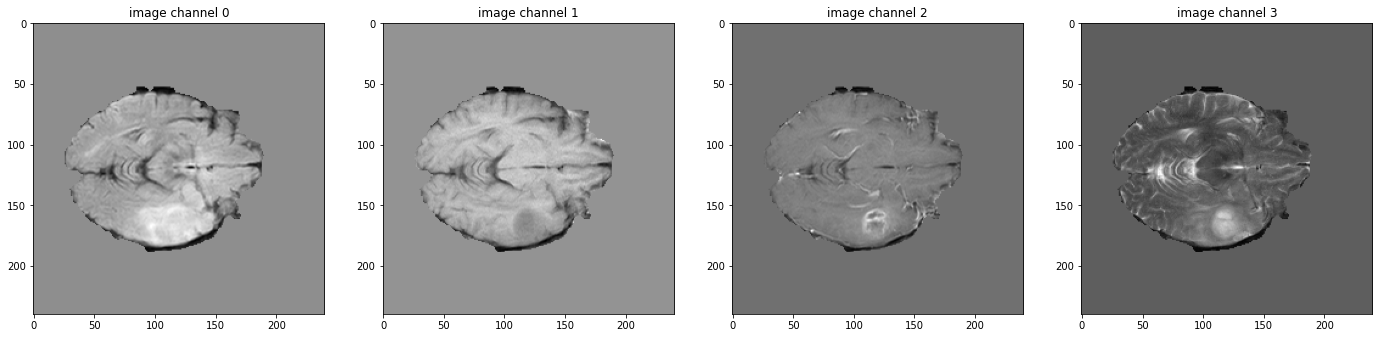

label shape: torch.Size([3, 240, 240, 155])


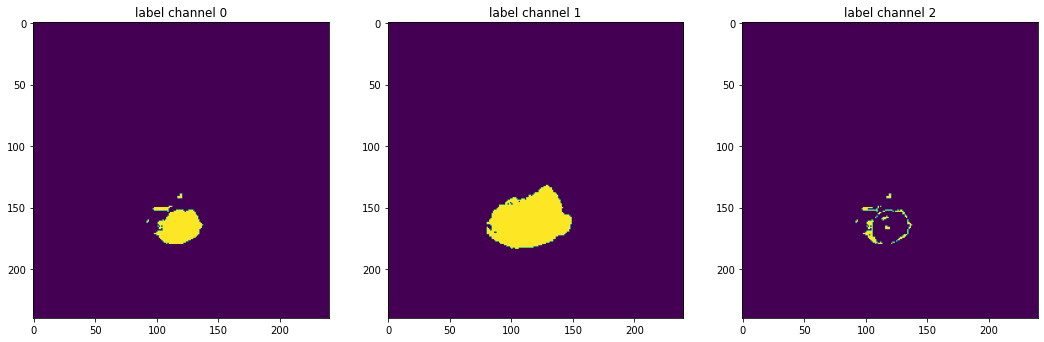

In [9]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
print(f"image shape: {val_ds[2]['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_ds[2]["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_ds[2]['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_ds[2]["label"][i, :, :, 60].detach().cpu())
plt.show()

In [10]:
## To collect information like subnets and security group to submit the training job with EFS data sources; 
import boto3
sm_client = boto3.client('sagemaker')
efs_client = boto3.client('efs')
ec2_client = boto3.client('ec2')
#sm_domains = sm_client.list_domains()
#sm_domain = sm_client.describe_domain( DomainId=sm_domains['Domains'][0]['DomainId'] )

#UserProfileName='bcarollo-amazon-com-113'      ## this is hard code UserProfile name in CFN template, please replace it if needed
#sm_user = sm_client.describe_user_profile(
#    DomainId=sm_domains['Domains'][0]['DomainId'],
#    UserProfileName=UserProfileName
#)

# Get EFS ID from Parameter Store
ssm_client = boto3.client("ssm")
efs_file_system_id = ssm_client.get_parameter(Name="SageMakerMonaiEFSIDParameter")["Parameter"]["Value"]
print(efs_file_system_id)
print()

mounttargets = efs_client.describe_mount_targets( FileSystemId = efs_file_system_id )
print()
print(mounttargets)




fs-00852537e14d4a163


{'ResponseMetadata': {'RequestId': '5bc25b1b-7598-4587-8686-8a140e2956d5', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '5bc25b1b-7598-4587-8686-8a140e2956d5', 'content-type': 'application/json', 'content-length': '1085', 'date': 'Sat, 11 Jun 2022 09:09:29 GMT'}, 'RetryAttempts': 0}, 'MountTargets': [{'OwnerId': '617011600974', 'MountTargetId': 'fsmt-0c89ab8ff2db93faa', 'FileSystemId': 'fs-00852537e14d4a163', 'SubnetId': 'subnet-0de45d1a41159c78a', 'LifeCycleState': 'available', 'IpAddress': '10.0.176.134', 'NetworkInterfaceId': 'eni-0baf665d4b953e700', 'AvailabilityZoneId': 'euw1-az3', 'AvailabilityZoneName': 'eu-west-1c', 'VpcId': 'vpc-0da51fe8b517f0ecd'}, {'OwnerId': '617011600974', 'MountTargetId': 'fsmt-0d6c68f29a8204207', 'FileSystemId': 'fs-00852537e14d4a163', 'SubnetId': 'subnet-0fe50fcf81dae58c2', 'LifeCycleState': 'available', 'IpAddress': '10.0.148.168', 'NetworkInterfaceId': 'eni-0986199de1e96b583', 'AvailabilityZoneId': 'euw1-az2', 'Ava

In [11]:
#mounttargets = efs_client.describe_mount_targets( FileSystemId=sm_domain['HomeEfsFileSystemId'] )
securitygroup = ec2_client.describe_security_groups(
    Filters=[
      {
        "Name":"group-id",
        "Values": efs_client.describe_mount_target_security_groups( 
          MountTargetId=mounttargets['MountTargets'][0]['MountTargetId'] 
        )['SecurityGroups']
      }
    ]
)['SecurityGroups'][0]
print()
print(securitygroup)
print()
print(securitygroup["GroupId"])

subnet_id = mounttargets['MountTargets'][0]['SubnetId']
subnet_id_1 = mounttargets['MountTargets'][1]['SubnetId']
subnet_id_2 = mounttargets['MountTargets'][2]['SubnetId']
print("SubnetId")
print(subnet_id)

training_securitygroup = securitygroup["GroupId"]
print(training_securitygroup)


{'Description': 'MonaiOnSagemakerInfrastructureStack/MonaiSagemakerEfsFileSystem/EfsSecurityGroup', 'GroupName': 'MonaiOnSagemakerInfrastructureStack-MonaiSagemakerEfsFileSystemEfsSecurityGroup043B95AE-DMUIIV5TBFF5', 'IpPermissions': [{'FromPort': 2049, 'IpProtocol': 'tcp', 'IpRanges': [{'CidrIp': '0.0.0.0/0', 'Description': 'Allow In connection on Default port from any IPv4 address'}], 'Ipv6Ranges': [], 'PrefixListIds': [], 'ToPort': 2049, 'UserIdGroupPairs': []}], 'OwnerId': '617011600974', 'GroupId': 'sg-0212654365db801e6', 'IpPermissionsEgress': [{'IpProtocol': '-1', 'IpRanges': [{'CidrIp': '0.0.0.0/0', 'Description': 'Allow all outbound traffic by default'}], 'Ipv6Ranges': [], 'PrefixListIds': [], 'UserIdGroupPairs': []}], 'Tags': [{'Key': 'Name', 'Value': 'MonaiOnSagemakerInfrastructureStack/MonaiSagemakerEfsFileSystem'}, {'Key': 'aws:cloudformation:stack-name', 'Value': 'MonaiOnSagemakerInfrastructureStack'}, {'Key': 'aws:cloudformation:stack-id', 'Value': 'arn:aws:cloudformati

In [12]:
print(torch.__version__)

1.11.0+cu102


In [14]:
import sagemaker
from sagemaker.inputs import FileSystemInput
from sagemaker.pytorch import PyTorch
sagemaker_session = sagemaker.Session()
sm_runtime = boto3.client("sagemaker-runtime")

sm_role = ssm_client.get_parameter(Name="MonaiOnSagemakerRoleParameter")["Parameter"]["Value"]
print(f"Using Role: {sm_role}")

s3_bucket = ssm_client.get_parameter(Name="MonaiOnSagemakerBucketParameter")["Parameter"]["Value"]
 
print(f"Will use bucket '{s3_bucket}' for storing all resources related to this notebook")

#bucket_prefix = "monai-async-inference-demo"
#resource_name = "MonaiAsyncInferenceDemo-{}-{}"


Using Role: arn:aws:iam::617011600974:role/MonaiOnSagemakerInfrastru-MonaiOnSagemakerRoleA19D-1QZWJMQNJ5369
Will use bucket 'monaionsagemakerinfrastr-monaionsagemakerbucket25-1strml4fipujp' for storing all resources related to this notebook


In [17]:


metrics=[
   {'Name': 'train:average epoch loss', 'Regex': 'average loss: ([0-9\\.]*)'},
   {'Name': 'train:current mean dice', 'Regex': 'current mean dice: ([0-9\\.]*)'},
   {'Name': 'train:best mean dice', 'Regex': 'best mean dice: ([0-9\\.]*)'}
]
training_securitygroup_ids = [training_securitygroup]
subnet_ids = [subnet_id, subnet_id_1, subnet_id_2]
#instance_type = 'ml.p3.2xlarge'
instance_type = 'ml.g4dn.xlarge'

instance_count = 1

monai_docker_image_url = ssm_client.get_parameter(Name="MonaiOnSagemakerContainerParameter")["Parameter"]["Value"]
print("Monai Docker Image Container URL: ", monai_docker_image_url)

estimator = PyTorch(source_dir='source',
                    entry_point='sagemaker_train.py',
                    role=sm_role,
                    framework_version='1.11.0',
                    py_version='py38',
                    image_uri = monai_docker_image_url,
                    instance_count=instance_count,
                    instance_type=instance_type,
                    subnets=subnet_ids,
                    security_group_ids=training_securitygroup_ids,
                    hyperparameters={
                       "seed": 2,
                       "lr": 0.001,
                       "epochs": 2
                    },
                    metric_definitions=metrics, 
                    output_path = "s3://" + s3_bucket
                )



In [18]:
file_system_input = FileSystemInput(
    file_system_id=efs_file_system_id,
    file_system_type='EFS',
    directory_path='/',
    file_system_access_mode='rw'
)

In [19]:
# Start an Amazon SageMaker training job with EFS using the FileSystemInput class
estimator.fit(file_system_input)

2022-06-11 08:26:12 Starting - Starting the training job...
2022-06-11 08:26:14 Starting - Launching requested ML instancesProfilerReport-1654935972: InProgress
......
2022-06-11 08:27:39 Starting - Preparing the instances for training......
2022-06-11 08:28:37 Downloading - Downloading input data
2022-06-11 08:28:37 Training - Downloading the training image.............................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/opt/conda/lib/python3.8/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
2022-06-11 08:33:20,805 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-06-11 08:33:20,824 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-06-11 08:33:27,091 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-06-11 

In [16]:
## hyperparameter tuning (optional to run)

objective_metric_name = 'train:current mean dice'

hyperparameter_ranges = {
    'lr': sagemaker.tuner.ContinuousParameter(0.001, 0.1),
    'epochs': sagemaker.tuner.CategoricalParameter([1, 5, 10])
}

tuner = sagemaker.tuner.HyperparameterTuner(
                            estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metrics,
                            max_jobs=1,
                            max_parallel_jobs=1,
                            objective_type='Maximize')

tuner.fit(file_system_input)

...................................................................................................................................................................................................................................................!
